# Guided Project #20. Creating a Kaggle Workflow
In this project we're going to create a workflow to make competing in the [Kaggle Titanic competition](https://www.kaggle.com/c/titanic/overview) easier, using a pipeline of functions to reduce the number of dimensions we need to focus on.

### 1. Reading in the data

In [2]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 2. Preprocessing the data
Using %load magic command let's load the functions we create earlier from functions.py file

In [7]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

Let's create data preprocessing function

In [9]:
def preprocess(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    cat_colums = ['Age_categories','Fare_categories','Title','Cabin_type','Sex']
    
    for col in cat_colums:
        df = create_dummies(df, col)
        
    return df

train = preprocess(train)
test = preprocess(test)

### 3. Exploring the data
The Kaggle workflow we are going to build will combine the following steps into a process. 
- **Data exploration**, to find patterns in the data
- **Feature engineering**, to create new features from those patterns or through pure experimentation
- **Feature selection**, to select the best subset of our current set of features
- **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

While the first two steps of our workflow are relatively freeform, later in this project we'll create some functions that will help automate the complexity of the latter two steps so we can move faster.

For now, let's practice the first stage, exploring the data. We're going to examine the two columns that contain information about the family members each passenger had onboard: *SibSp* and *Parch*.

In [12]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [13]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

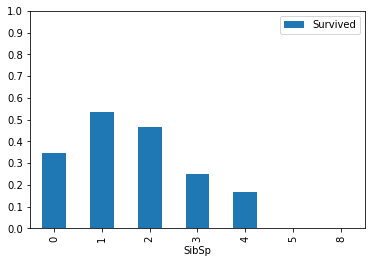

In [43]:
from matplotlib import pyplot as plt
survival_by_sibsp = train.pivot_table(index='SibSp', values='Survived')
survival_by_sibsp.plot.bar(ylim=(0,1), yticks=np.arange(0,1.1,0.1))
# plt.xticks

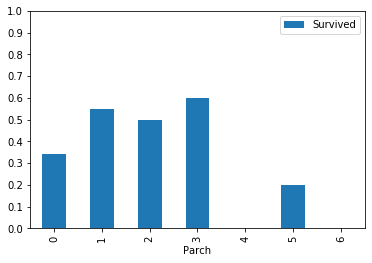

In [44]:
survival_by_parch = train.pivot_table(index='Parch', values='Survived')
survival_by_parch.plot.bar(ylim=(0,1), yticks=np.arange(0,1.1,0.1))

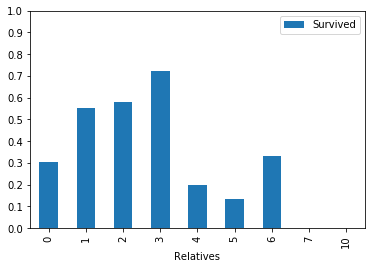

In [42]:
train['Relatives'] = train['Parch']+train['SibSp']
survival_by_relatives = train.pivot_table(index='Relatives', values='Survived')
survival_by_relatives.plot.bar(ylim=(0,1), yticks=np.arange(0,1.1,0.1))

### 4. Engineering new features

Looking at the plot above, we can see that only 30% of the passengers who had no family members onboard survived.

Based of this, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

- 1 if the passenger has zero family members onboard
- 0 if the passenger has one or more family members onboard

Let's go ahead and create this feature.

In [50]:
def process_relatives(df):
    df['Relatives'] = df['Parch']+df['SibSp']
    df['isalone'] = (df['Relatives'] == 0).astype(int)
    return df

train = process_relatives(train)
test = process_relatives(test)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,Relatives,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,1,0,1,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,1,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,1,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,1,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,1,0,1,0,1


### 5. Selecting the best performing features
The next step in our workflow is feature selection. We cab use scikit-learn's feature_selection.RFECV class to automate selecting the best-performing features using recursive feature elimination.

Let's write a function that:

- Accepts a dataframe as input
- Performs data preparation for machine learning
- Uses recursive feature elimination and the random forests algorithm to find the best-performing set of features

In [106]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes(include=np.number)
    df = df.dropna(axis=1)
    
    all_X = df.drop(columns=['PassengerId','Survived'])
    all_y = df['Survived']
    
    rf = RandomForestClassifier(n_estimators=100, random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X,all_y)
  
    best_cols = all_X.columns[selector.support_]
    print(best_cols)
  
    return best_cols

In [107]:
features = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'Relatives', 'isalone'],
      dtype='object')


### 6. Selecting and tuning models
Just like we did with feature selection, we can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

We can achieve this by creating a list of dictionaries — that is, a list where each element of the list is a dictionary. Each dictionary should contain:

- The name of the particular model
- An estimator object for the model
- A dictionary of hyperparameters that we'll use for grid search.

Here's an example of what one of these dictionaries will look like:

    {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
    }
    
We can then use a for loop to iterate over the list of dictionaries, and for each one we can use scikit-learn's model_selection.GridSearchCV class to find the best set of performing parameters, and add values for both the parameter set and the score to the dictionary.

Finally, we can return the list of dictionaries, which will have our trained GridSearchCV objects as well as the results so we can see which was the most accurate.

In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    models = [{'name':'LogisticRegression',
               'estimator':LogisticRegression(),
               'hyperparameters': {
                   "solver": ["newton-cg", "lbfgs", "liblinear"]
               }
              },
               {'name':'KNeighborsClassifier', 
                'estimator':KNeighborsClassifier(),
                'hyperparameters': {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
               },
              {'name':'RandomForestClassifier',
               'estimator':RandomForestClassifier(),
               'hyperparameters': {
                   "n_estimators": [4, 6, 9],
                   "criterion": ["entropy", "gini"],
                   "max_depth": [2, 5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5, 8],
                   "min_samples_split": [2, 3, 5]
               }
              }
             ]
    
    for model in models:
        print(model['name'])
        selector = GridSearchCV(model['estimator'], 
                               param_grid=model['hyperparameters'],
                               cv=10)
        selector.fit(all_X, all_y)
        model['best_params'] = selector.best_params_
        model['best_score'] = selector.best_score_
        model['best_estimator'] = selector.best_estimator_
    
    return models

models = select_model(train, features)

LogisticRegression


/Users/serhio/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/serhio/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/serhio/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/serhio/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/serhio/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number 

KNeighborsClassifier
RandomForestClassifier


### 7. Creating a submission file
After running select_model() function, we have three scores from three different models. At this point in the workflow we have a decision to make: Do we want to train your best model on the holdout set and make a Kaggle submission, or do we want to go back to engineering features.

We may find that adding a feature to our model doesn't improve accuracy. In that case we should go back to data exploration and repeat the cycle again.

If we're going to be continually submitting to Kaggle, a function will help make this easier. Let's create a function to automate this.

In [109]:
def save_submission_file(estimator, features, filename='submission.csv'):
    predictions = estimator.predict(test[features])
    submission = pd.DataFrame({
        "PassengerId":test['PassengerId'],
        "Survived":predictions
    })
    submission.to_csv(filename, index=False)

In [110]:
for mod in models:
    print(mod['name'], mod['best_score'])

LogisticRegression 0.8215488215488216
KNeighborsClassifier 0.7822671156004489
RandomForestClassifier 0.8395061728395061


In [111]:
best_model = models[2]['best_estimator']
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [112]:
save_submission_file(best_model, features)

In [113]:
features

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'Relatives', 'isalone'],
      dtype='object')

### 8. Next Steps
In this guided project, we created a reproducible workflow to help us iterate over ideas and continue to improve the accuracy of our predictions. We also created helper functions which will make feature selection, model selection/tuning and creating submissions much easier as we continue to explore the data and create new features.

Here are some suggestions of next steps:

- Continue to explore the data and create new features, following the workflow and using the functions we created.
- Read more about the titanic and this Kaggle competition to get ideas for new features.
- Use some different algorithms in the select_model() function, like [support vector machines](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [stochastic gradient descent](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) or [perceptron](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) linear models.
- Experiment with RandomizedSearchCV instead of GridSearchCV to speed up your select_features() function.

Lastly, while the Titanic competition is great for learning about how to approach your first Kaggle competition, we recommend against spending many hours focused on trying to get to the top of the leaderboard. With such a small data set, there is a limit to how good your predictions can be, and your time would be better spent moving onto more complex competitions.

Once you feel like you have a good understanding of the Kaggle workflow, you should look at some other competitions - a great next competition is the [House Prices Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). We have a great [tutorial](https://www.dataquest.io/blog/kaggle-getting-started/) for getting started with this competition on our blog.

Curious to see what other students have done on this project? Head over to our [Community](https://community.dataquest.io/tags/c/social/share/49/188) to check them out. While you are there, please remember to show some love and give your own feedback!